# Landmarks (OSM Data)
Four scores are here computed to extract computation landmarks: structural, visual, pragmatic.
Currently, the user has to provide the building shapefile, collected independently. The height is the only necessary field, plus two datasets containing respectively information about cultural/historical landmarks (e.g. position of listed important buildings) and land-use.

In [1]:
import osmnx as ox, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

## Obtaining the Data

Fill the list 'places' with the names of the cities of interest. Buildings footprints are dowloaded for each city from OpenStreetMap within a certain distance from the centre of each city. The distance is set by the user. Each geodataframe is projected automatically (check OSMNx documentation for more information). The geodataframes are then cleaned and only relevant columns are kept. 

In [2]:
distance_from_center = 1000
places = ['London, UK', 'Torino, Italy', 'Berlin, Germany', 'Beograd, Serbia', 'New York, US', 'Cairo, Egypt']
buildings_gdfs = []

for place in places:
    buildings_gdf = ci.get_buildings_fromOSM(place, 'distance_from_address', epsg = None, distance = distance_from_center)
    buildings_gdfs.append(buildings_gdf)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\landmarks.py:137: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  buildings_gdf['land_use_raw'].replace('nan', np.nan, inplace=True)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\landmarks.py:137: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior,

**Visualisation**

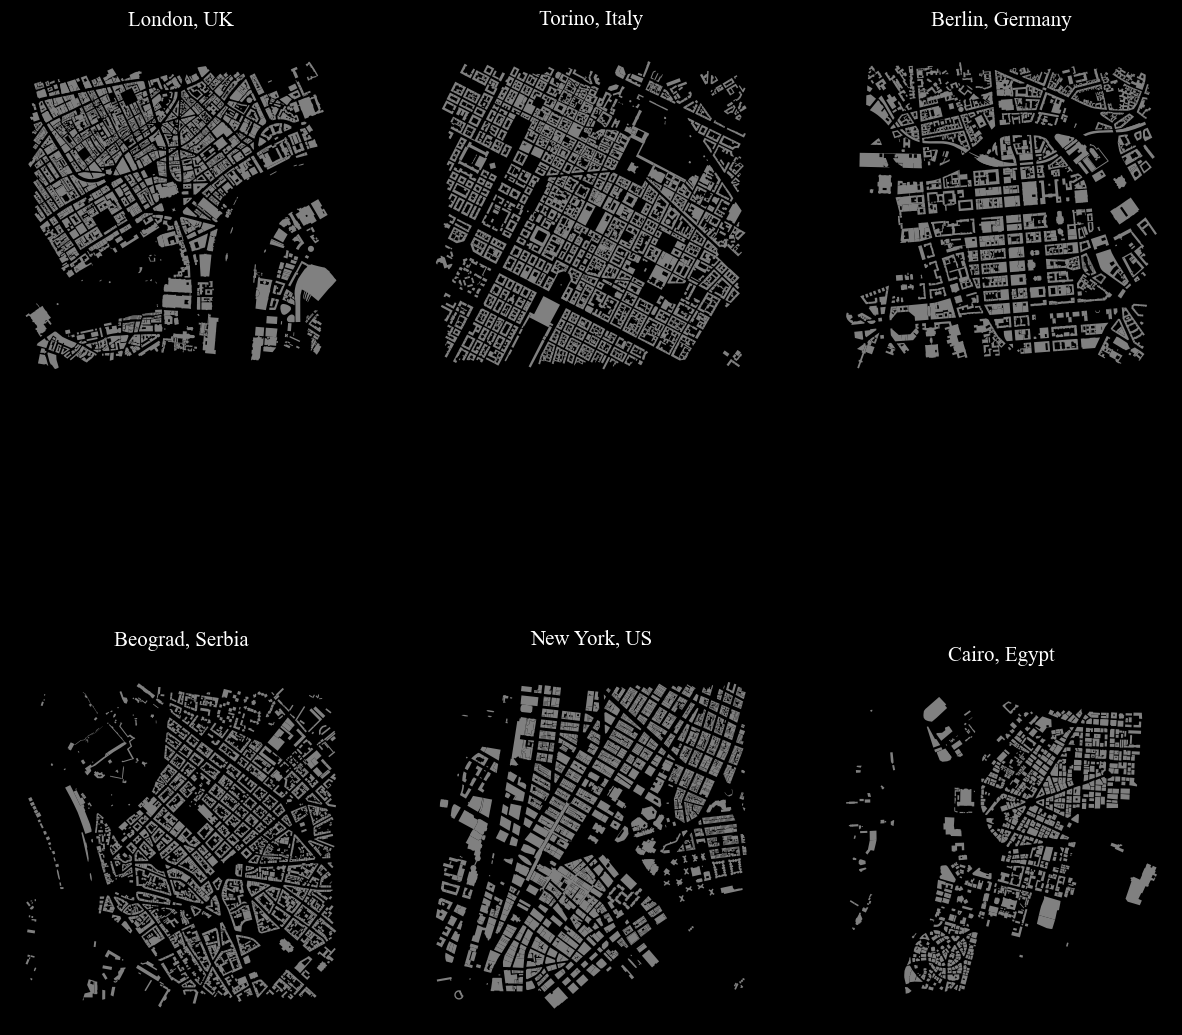

In [8]:
fig = ci.plot_grid_gdfs_column(gdfs = buildings_gdfs, titles = places, figsize = (15,15), color = 'grey', black_background = True,
                              nrows = 2, ncols = 3)

## Structural, Visual and Cultural score computations

### Structural Component

It considers:

* The area of the building.
* Its distance from the road.
* The number of adjacent buildings, within the given `neighbours_radius`, around it.
* A measure of 2d advance visibility, expanded till a maximum distance from the center of the building on the basis of the `advance_vis_expansion_distance` parameter.

In [11]:
sn = []
for n, city in enumerate(places):
    # reading the street network
    _, edges_graph = ci.get_network_fromOSM(place = city, download_method = 'distance_from_address', 
                                            distance = distance_from_center,
                                            network_type = 'walk', epsg = epsg)
    ox.projection.project_gdf(streets_gdf)
    sn.append(streets_gdf)

for n, city in enumerate(places):
    # structural score
    obstructions = buildings.copy()
    edges = sn[nb]
    buildings_gdfs[n] = ci.structural_score(buildings, obstructions, edges, advance_vis_expansion_distance = 300, 
                                neighbours_radius = 150)

NameError: name 'crs' is not defined

## Visual Component

In [ ]:
for n, city in enumerate(places):
    # visual score: not really computed at the moment as in most of the cases height information is not provided in OSM
    buildings_gdfs[n] = ci.visibility_score(buildings_gdfs[n])

## Cultural Component

In [ ]:
for n, city in enumerate(places):
    # culturalscore:
    buildings_gdfs[n] = ci.cultural_score_from_OSM(buildings_gdfs[n])

## Pragmatic Score

In [ ]:
# pragmatic score
    """
    The "radius" parameter indicates the extension of the area that is used to compute the score of a building, on the basis of
    its land-use's frequency, in an area of 'buffer' meters around it.
    """
    buildings_gdfs[n] = ci.classify_land_use(buildings_gdfs[n], 'land_use') #check function for classification methodology
    buildings_gdfs[n] = ci.pragmatic_score(buildings_gdfs[n], radius = 200)

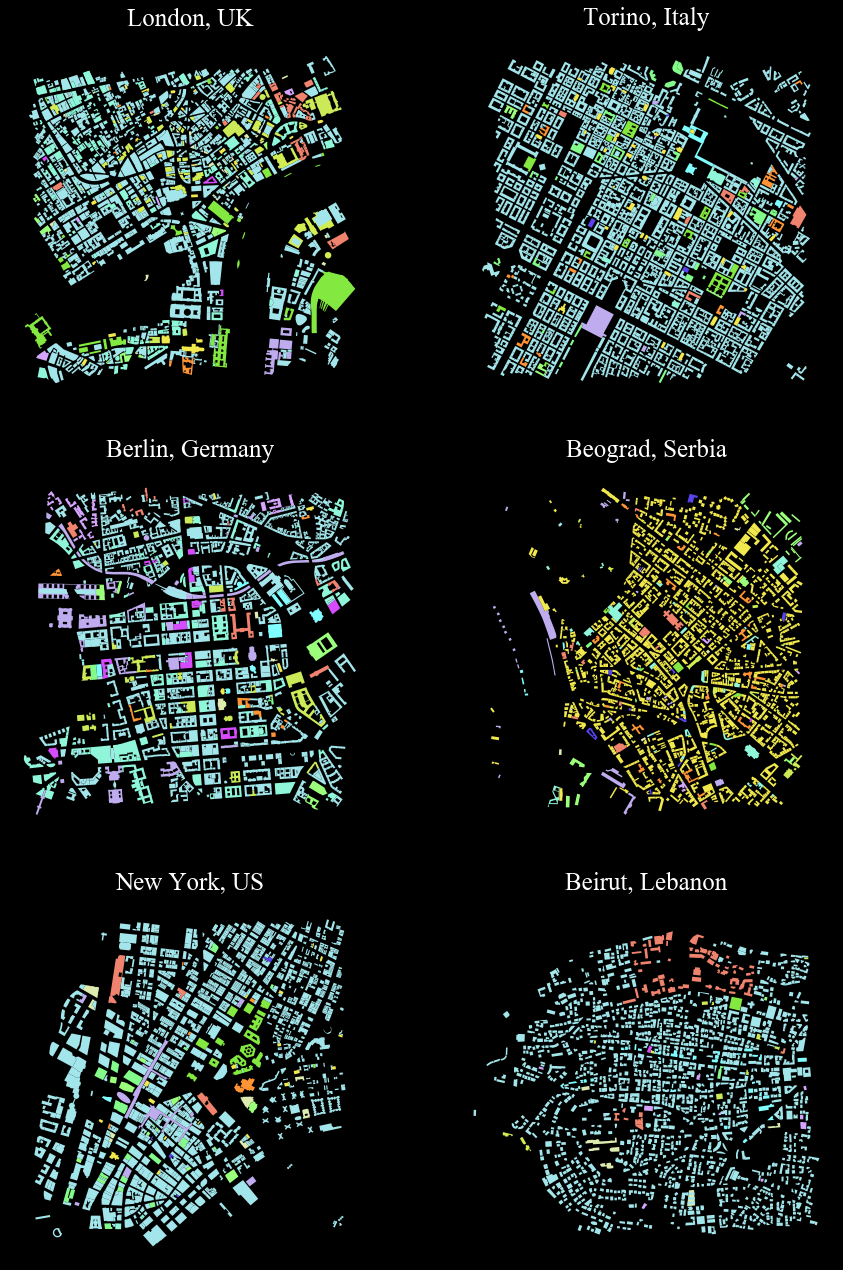

In [421]:
# visualising land use categorisation
nr_categories = max([len(gdf['land_use'].unique()) for gdf in buildings_gdfs])
cmap = ci.rand_cmap(nr_categories, type_color = 'bright')
fig = ci.plot_gdfs(buildings_gdfs,titles = places, cmap = cmap, column = 'land_use')

# 5 - Final scores

### Weights definition.
#### Weights of components and indexes that are not computed due to data availability are set to 0

In [5]:
# global landmarkness components weights
g_cW = {'vScore': 0.00, 'sScore' : 0.60, 'cScore': 0.10, 'pScore': 0.30}
# global landmarkness indexes weights, cScore and pScore have only 1 index each
g_iW = {'3dvis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, '2dvis': 0.00, 'neigh': 0.30 , 'road': 0.20}

# # local landmarkness components weights
l_cW = {'vScore': 0.05, 'sScore' : 0.45, 'cScore':0.10 , 'pScore': 0.45}
# # local landmarkness indexes weights, cScore and pScore have only 1 index each
l_iW = {'3dvis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, '2dvis': 0.00, 'neigh': 0.30 , 'road': 0.20}

In [7]:
# Global and Local Score (1500 mt area)
for n, city in enumerate(places):
    buildings_gdfs[n] = ci.compute_global_scores(buildings_gdfs[n], g_cW, g_iW)
    buildings_gdfs[n] = ci.compute_local_scores(buildings_gdfs[n], l_cW, l_iW, 1500)

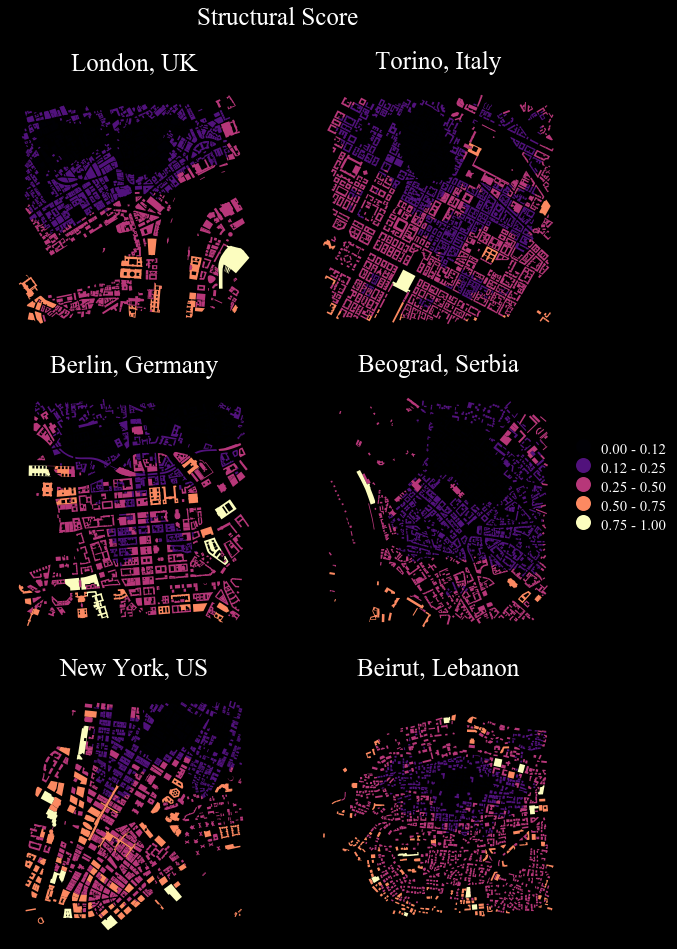

In [434]:
# visualising the four componets' maps, the color bar can be activated adding: cbar = True
fig = plot_gdfs(buildings_gdfs, main_title = "Structural Score", titles = places, classes = 7, column = 'sScore_sc',
                cmap = 'magma', scheme = 'Lynch_Breaks', legend = True, fig_size = 10)

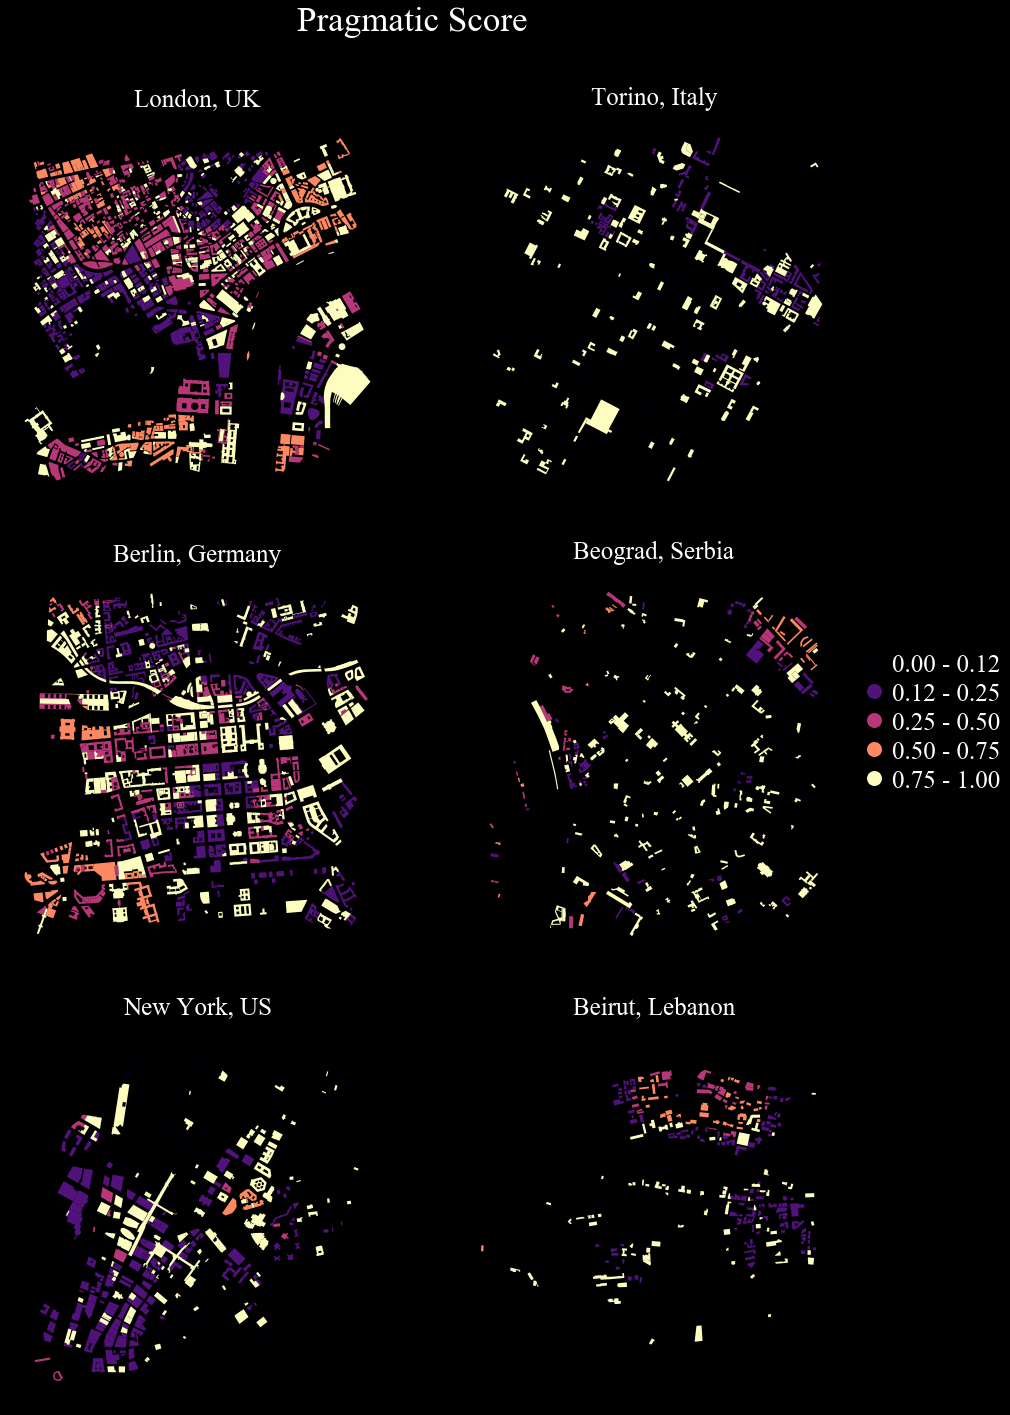

In [416]:
fig = ci.plot_gdfs(buildings_gdfs, main_title = "Pragmatic Score", titles = places, column = 'pScore',
                cmap = 'magma', scheme = 'Lynch_Breaks', legend = True)

In [433]:
buildings_gdfs[0].lScore_sc

858    nan
954    nan
1078   nan
1092   nan
1230   nan
        ..
397    nan
1455   nan
1112   nan
324    nan
321    nan
Name: lScore_sc, Length: 1489, dtype: float64

ValueError: Fewer unique values than specified classes.

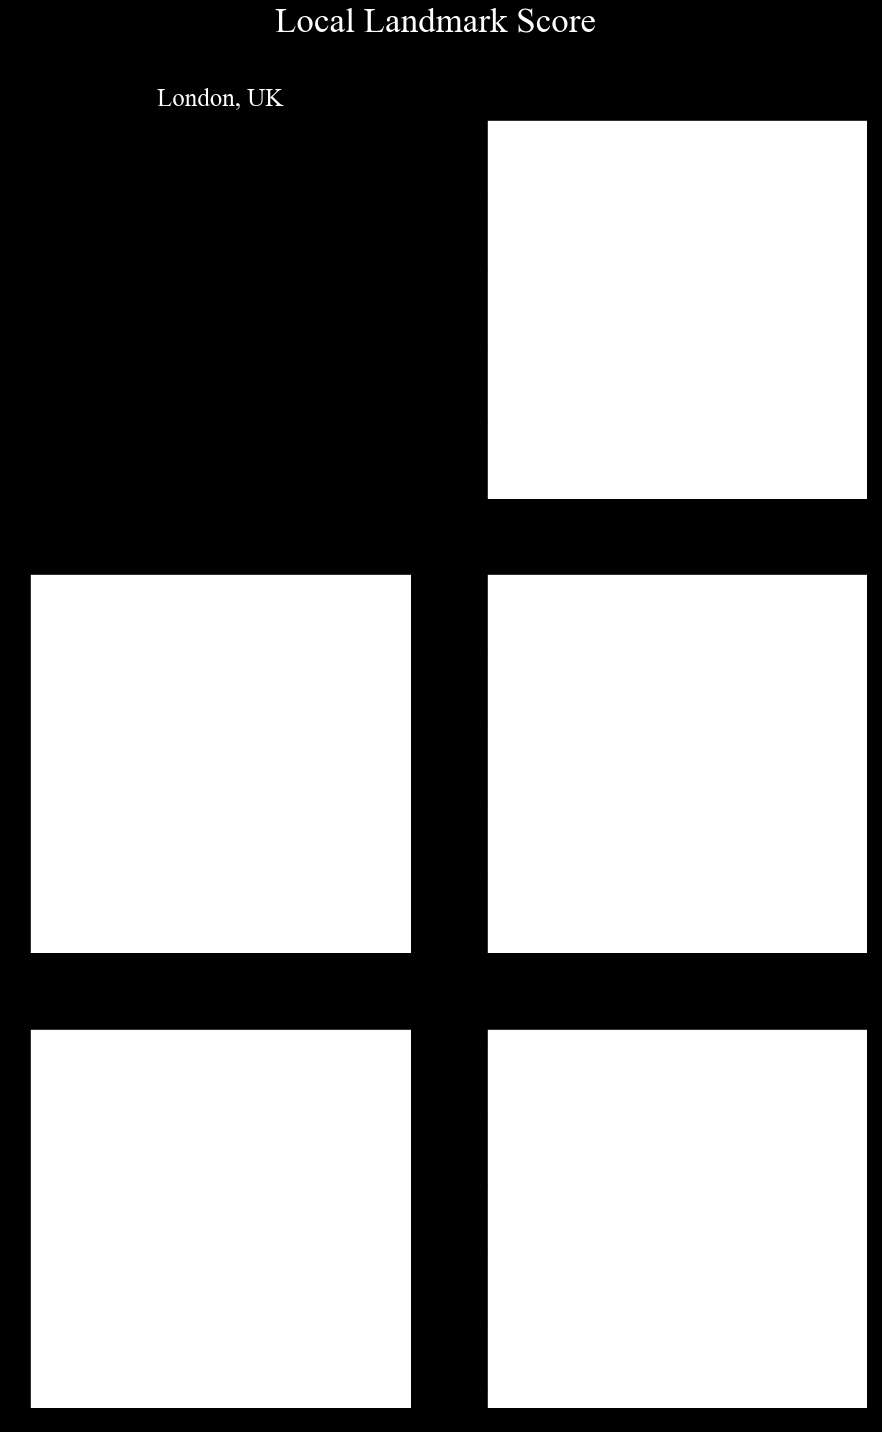

In [430]:
fig = plot_gdfs(buildings_gdfs, main_title = "Local Landmark Score", titles = places, column = 'lScore',
                cmap = 'magma', scheme = 'Fisher_Jenks', legend = True)

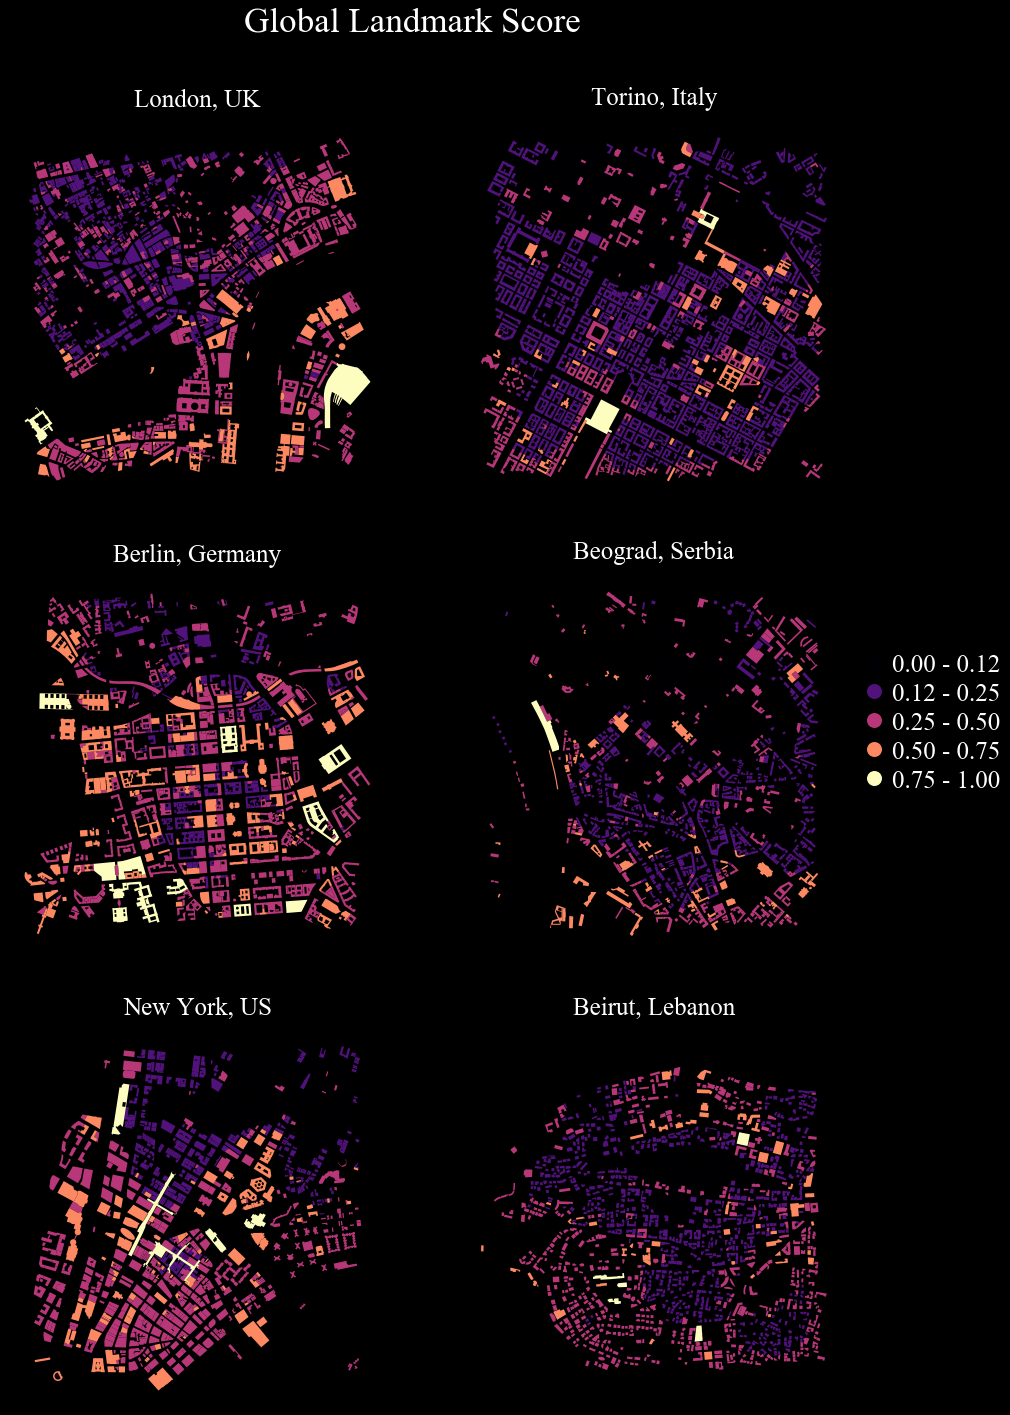

In [414]:
fig = ci.plot_gdfs(buildings_gdfs, main_title = "Global Landmark Score", titles = places, column = 'gScore_sc',
                cmap = 'magma', scheme = 'Lynch_Breaks', legend = True)